## Analyze Dataset Performance

As demonstrated in the README's RIP example scripts, the user can set `--debug_collect_dataset_stats=True` and cache statistics and performance over the validation datasets to file.

This script provides some analysis utilities for plotting and understanding a model's performance on various subsets of the data.

In [23]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pylab as plt

In [24]:
# full_model_name takes a format such as rip-bc-k_3-plan_ma-scene_ma
# for a RIP ensemble with the Behavioral Cloning backbone, 3 ensemble members, and
# model averaging (mean) aggregation over per-plan and per-scene confidence scores.
# For more details, see `sdc.oatomobile.torch.baselines.robust_imitative_planning.py`.

dir_metadata_cache = '/path/to/metadata_cache/full_model_name'

In [25]:
with open(os.path.join(dir_metadata_cache, 'request.tsv')) as f:
    request_df = pd.read_csv(f, sep='\t')
    
with open(os.path.join(dir_metadata_cache, 'scene.tsv')) as f:
    scene_df = pd.read_csv(f, sep='\t')

In [26]:
# Join prediction_request_df and scene_df on scene_id
merged_df = pd.merge(request_df, scene_df, on=['scene_ids'])

In [27]:
merged_df.head()

,pred_request_confidence_scores,request_ids,kMoveLeft,kMoveRight,kMoveForward,kMoveBack,kAcceleration,kDeceleration,kUniform,kStopping,...,track__TelAviv,sun_phase__kAstronomicalNight,sun_phase__kTwilight,sun_phase__kDaylight,precipitation__kNoPrecipitation,precipitation__kRain,precipitation__kSleet,precipitation__kSnow,dataset_key_y,run_datetime_y
0,-94.471010,645,False,False,True,False,True,False,False,False,...,0,-1,-1,-1,-1,-1,-1,-1,moscow__train,2021-06-22 22:23:01.862554
1,-38.219746,4176,True,False,False,False,False,False,True,False,...,0,-1,-1,-1,-1,-1,-1,-1,moscow__train,2021-06-22 22:23:01.862554
2,-106.500980,4308,False,False,True,False,True,False,True,False,...,0,-1,-1,-1,-1,-1,-1,-1,moscow__train,2021-06-22 22:23:01.862554
3,-30.564758,4319,False,False,True,False,True,False,True,False,...,0,-1,-1,-1,-1,-1,-1,-1,moscow__train,2021-06-22 22:23:01.862554
4,-8.978527,4326,False,False,True,False,True,False,False,False,...,0,-1,-1,-1,-1,-1,-1,-1,moscow__train,2021-06-22 22:23:01.862554


In [28]:
dataset_keys = set(merged_df['dataset_key_y'])

In [29]:
# All datasets for which a prediction was collected
dataset_keys

{'moscow__test',
 'moscow__train',
 'moscow__validation',
 'moscow_precip__test',
 'ood__test',
 'ood__validation'}

In [30]:
moscow_val_rows = merged_df[merged_df['dataset_key_y'] == 'moscow__validation']
ood_val_rows = merged_df[merged_df['dataset_key_y'] == 'ood__validation']

In [31]:
# Average confidence on the Moscow and OOD validation sets, respectively
moscow_val_rows.pred_request_confidence_scores.mean(), ood_val_rows.pred_request_confidence_scores.mean()

(37.875868411649165, 43.42632428682767)

In [32]:
# Average minADE on the same validation sets
moscow_val_rows['minADE'].mean(), ood_val_rows['minADE'].mean()

(1.520891741589682, 1.1380318261310458)

<Figure size 1440x720 with 0 Axes>

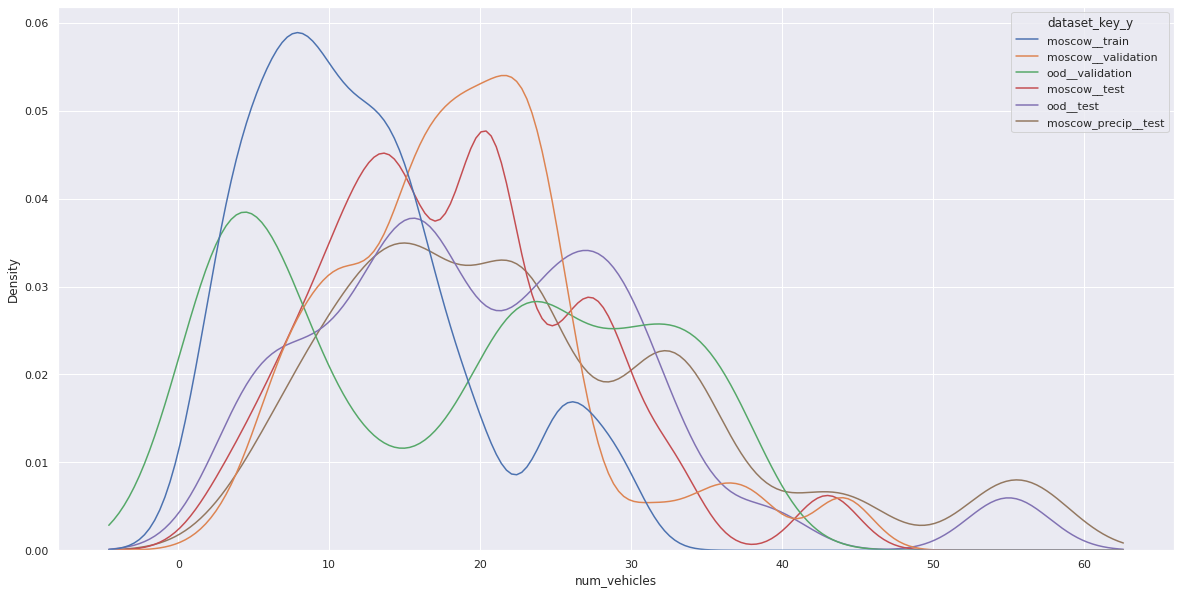

<Figure size 1440x720 with 0 Axes>

In [42]:
# Distribution of number of vehicles in each dataset
sns.kdeplot(
    data=merged_df, x="num_vehicles", hue="dataset_key_y",
    common_norm=False, common_grid=True)
plt.figure(figsize=(20,10))

### Trajectory Tag Plots
Note that trajectory tags are not mutually exclusive. We report a metric of choice when fixing a given tag (e.g., `kMoveBack`) to be present or absent.

In [ ]:
TRAJECTORY_TAGS = [
 'kMoveLeft',
 'kMoveRight',
 'kMoveForward',
 'kMoveBack',
 'kAcceleration',
 'kDeceleration',
 'kUniform',
 'kStopping',
 'kStarting',
 'kStationary'
]
chosen_metric = 'minADE'

In [35]:
import numpy as np
from collections import defaultdict

data = defaultdict(list)
for dataset_key in dataset_keys:
    print('\n')
    print('Computing statistics for dataset', dataset_key)
    dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
    for traj_tag in TRAJECTORY_TAGS:
        n_present_absent = []
        for toggle in [1, 0]:
            traj_tag_df = dataset_df[dataset_df[traj_tag] == toggle]
            perc = np.round(100 * (len(traj_tag_df) / len(dataset_df)))
            n_present_absent.append(len(traj_tag_df))
            data['dataset'].append(dataset_key)
            data['traj_tag'].append(f'{traj_tag}__{str(toggle)}')
            data['val'].append(traj_tag_df[chosen_metric].mean())
            
        print(f'{traj_tag}: Present {n_present_absent[0]} | Absent {n_present_absent[1]}')



Computing statistics for dataset  moscow__validation
kMoveLeft: Present 38 | Absent 1421
kMoveRight: Present 47 | Absent 1412
kMoveForward: Present 723 | Absent 736
kMoveBack: Present 7 | Absent 1452
kAcceleration: Present 528 | Absent 931
kDeceleration: Present 0 | Absent 1459
kUniform: Present 1076 | Absent 383
kStopping: Present 82 | Absent 1377
kStarting: Present 87 | Absent 1372
kStationary: Present 482 | Absent 977


Computing statistics for dataset  moscow_precip__test
kMoveLeft: Present 36 | Absent 1613
kMoveRight: Present 51 | Absent 1598
kMoveForward: Present 749 | Absent 900
kMoveBack: Present 5 | Absent 1644
kAcceleration: Present 515 | Absent 1134
kDeceleration: Present 0 | Absent 1649
kUniform: Present 1316 | Absent 333
kStopping: Present 99 | Absent 1550
kStarting: Present 149 | Absent 1500
kStationary: Present 612 | Absent 1037


Computing statistics for dataset  moscow__train
kMoveLeft: Present 22 | Absent 672
kMoveRight: Present 22 | Absent 672
kMoveForward: Present

<Figure size 1440x720 with 0 Axes>

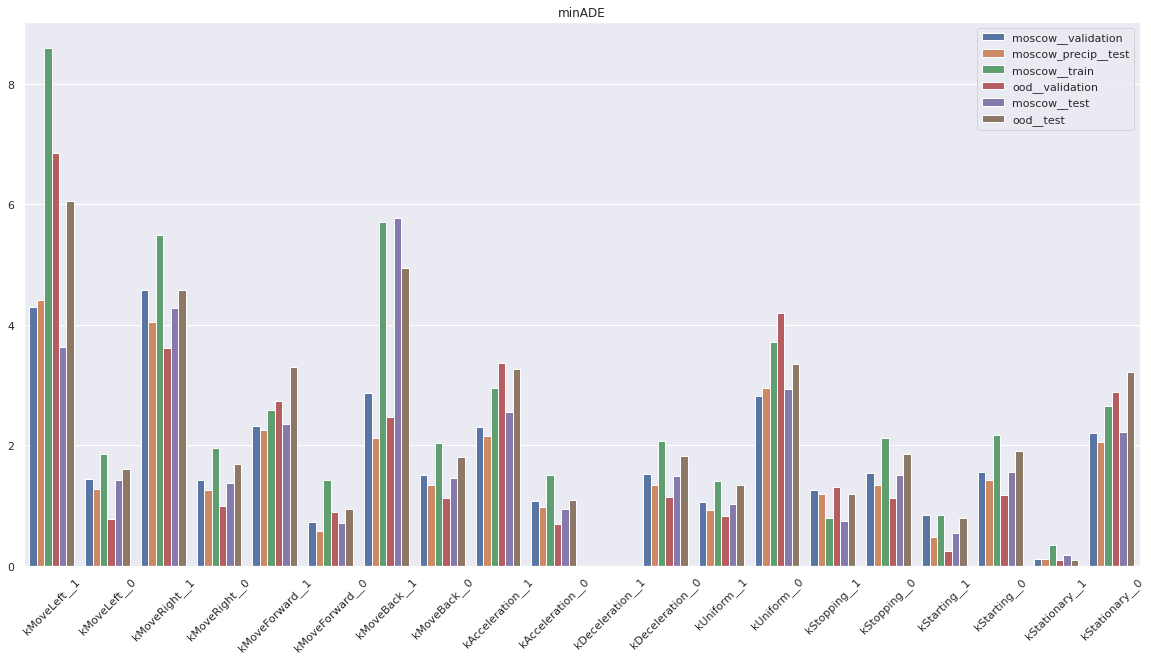

<Figure size 1440x720 with 0 Axes>

In [38]:
plt.xticks(rotation=45)
plt.title(chosen_metric)
ax = sns.barplot(x="traj_tag", y="val", hue="dataset", data=data)
plt.figure(figsize=(20,10))

## Mutually Exclusive Bar Groupings

In [44]:
def plot_mutually_exclusive_bar_groupings(metric, groups):
    data = defaultdict(list)
    for dataset_key in dataset_keys:
        print('Computing statistics for dataset', dataset_key)
        dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
        for group in groups:
            print(group)
            filt_df = dataset_df[dataset_df[group] == True]
            perc = np.round(100 * (len(filt_df) / len(dataset_df)))
            data['dataset'].append(dataset_key)
            data['group'].append(group)
            data['val'].append(filt_df[metric].mean())
            
    plt.title(metric)
    ax = sns.barplot(x="group", y="val", hue="dataset", data=data)
    plt.figure(figsize=(20,10))
    
metric = 'avgADE'

### Times of Day

Computing statistics for dataset  moscow__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset  moscow_precip__test
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset  moscow__train
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset  ood__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset  moscow__test
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset  ood__test
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening


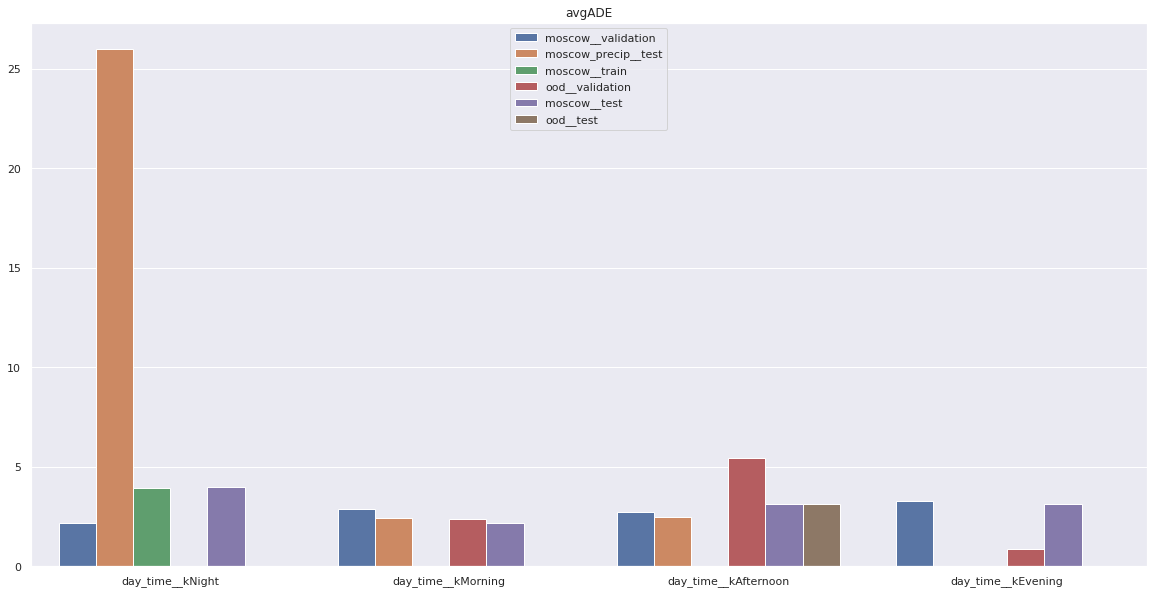

<Figure size 1440x720 with 0 Axes>

In [45]:
TIMES_OF_DAY = [
 'day_time__kNight',
 'day_time__kMorning',
 'day_time__kAfternoon',
 'day_time__kEvening',
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=TIMES_OF_DAY)

### Seasons

Computing statistics for dataset  moscow__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset  moscow_precip__test
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset  moscow__train
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset  ood__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset  moscow__test
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset  ood__test
season__kWinter
season__kSpring
season__kSummer
season__kAutumn


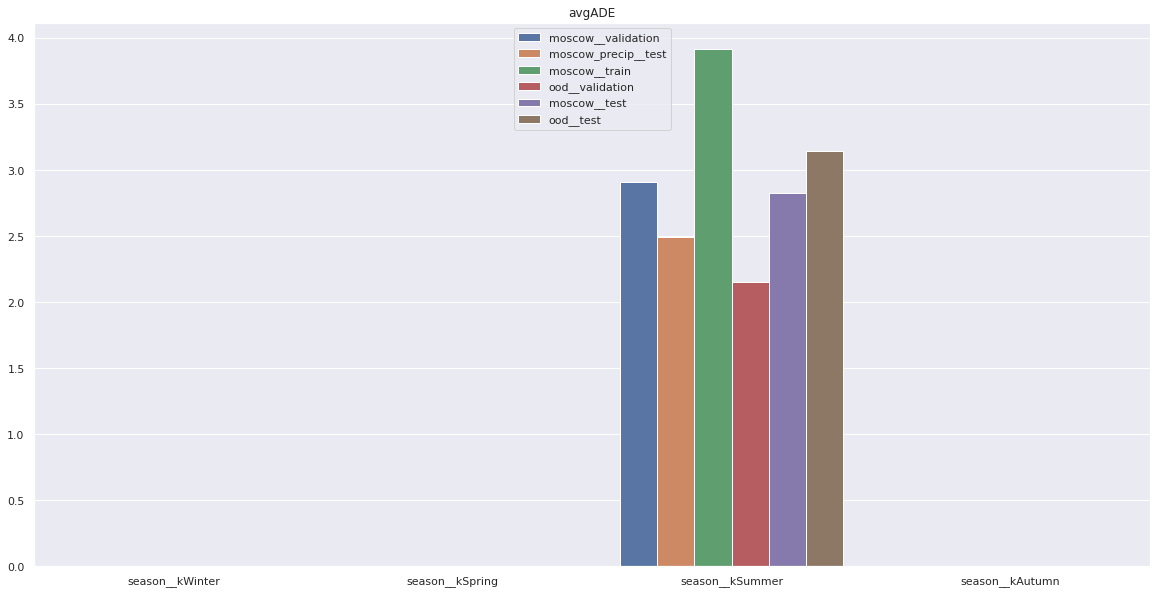

<Figure size 1440x720 with 0 Axes>

In [46]:
SEASONS = [
 'season__kWinter',
 'season__kSpring',
 'season__kSummer',
 'season__kAutumn',
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=SEASONS)

### City

Computing statistics for dataset  moscow__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset  moscow_precip__test
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset  moscow__train
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset  ood__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset  moscow__test
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset  ood__test
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv


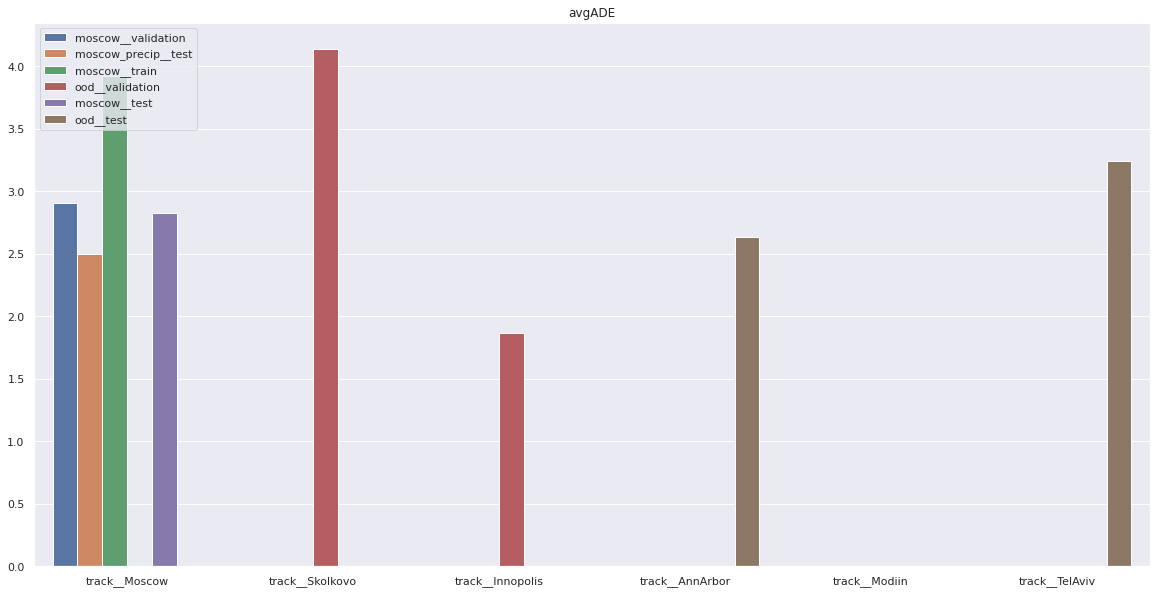

<Figure size 1440x720 with 0 Axes>

In [47]:
CITY = [
 'track__Moscow',
 'track__Skolkovo',
 'track__Innopolis',
 'track__AnnArbor',
 'track__Modiin',
 'track__TelAviv'
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=CITY)

### Precipitation

Computing statistics for dataset  moscow__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset  moscow_precip__test
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset  moscow__train
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset  ood__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset  moscow__test
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset  ood__test
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow


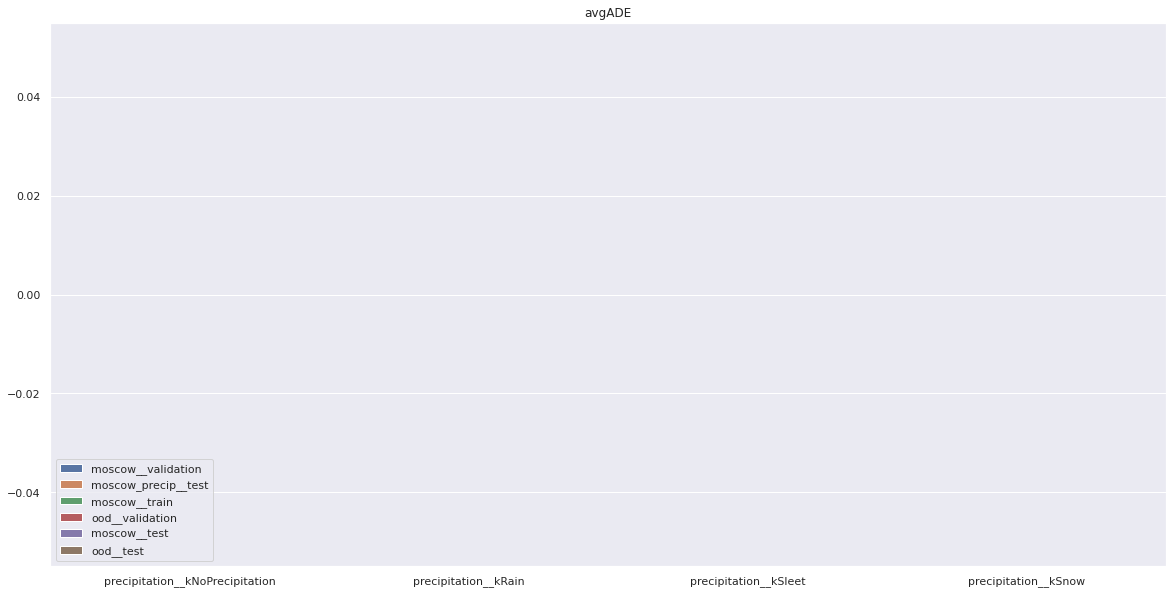

<Figure size 1440x720 with 0 Axes>

In [48]:
PRECIPITATION = [
 'precipitation__kNoPrecipitation',
 'precipitation__kRain',
 'precipitation__kSleet',
 'precipitation__kSnow',
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=PRECIPITATION)

## Confidence Quality

In [52]:
# Compute correlation of avg/minADE wrt confidence, stratified by trajectory tag
metric = 'avgADE'

for dataset_key in dataset_keys:
    for trajectory_tag in TRAJECTORY_TAGS:
        dataset_df = merged_df[(
            merged_df['dataset_key_y'] == dataset_key) &
            (merged_df[trajectory_tag] == True)]
        corr_df = dataset_df[['pred_request_confidence_scores', metric]]
        print('-----')
        print(dataset_key, trajectory_tag)
        print(corr_df.corr(method='pearson'))

-----
moscow__validation kMoveLeft
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.599838
avgADE                                               -0.599838  1.000000
-----
moscow__validation kMoveRight
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.510581
avgADE                                               -0.510581  1.000000
-----
moscow__validation kMoveForward
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.428893
avgADE                                               -0.428893  1.000000
-----
moscow__validation kMoveBack
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.406111
avgADE                                               

                                pred_request_confidence_scores   avgADE
pred_request_confidence_scores                         1.00000 -0.40536
avgADE                                                -0.40536  1.00000
-----
ood__test kStopping
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.429129
avgADE                                               -0.429129  1.000000
-----
ood__test kStarting
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.031699
avgADE                                               -0.031699  1.000000
-----
ood__test kStationary
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.201759
avgADE                                               -0.201759  1.000000
